In [1]:
!pip install catboost
!pip install nb_black

     |████████████████████████████████| 12.7 MB 3.0 MB/s eta 0:00:01    |██████▊                         | 2.7 MB 3.0 MB/s eta 0:00:04
     |████████████████████████████████| 46 kB 2.8 MB/s  eta 0:00:01
     |████████████████████████████████| 27.7 MB 18.5 MB/s eta 0:00:01   |▎                               | 276 kB 3.5 MB/s eta 0:00:08     |████▍                           | 3.8 MB 3.5 MB/s eta 0:00:07


In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

import catboost as cb

# wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
wids_path = ".."
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
import utils.model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [3]:
feature_dict = {
    "compare_impute_log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "compare_impute_log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "compare_impute_log_temp_pca_onehot_xgb_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    
}

<IPython.core.display.Javascript object>

Fitting PCA with 9 components


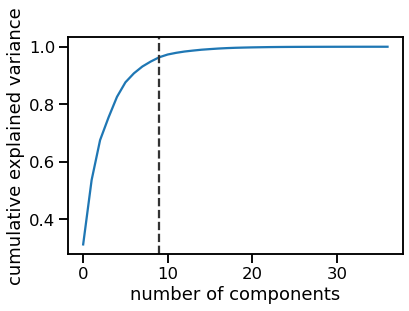

<IPython.core.display.Javascript object>

In [30]:
config_name = "compare_impute_log_temp_pca_onehot_impute"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]

train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates(),
    test_df.drop_duplicates(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

In [31]:
if config_name == "compare_impute_log_temp_pca_onehot_xgb_impute":
    predicted_impute_df = pd.read_csv(f"{wids_path}/feature_impute_data/energy_star_rating_by_year_non_weather_onehot_xgb_test_prediction.csv")
    train_filter_df = train_filter_df.merge(
        predicted_impute_df[["id", "predict_energy_star_rating"]], on = "id", how = "left"
    )
    train_filter_df["backfilled_energy_star_rating"] = train_filter_df["energy_star_rating"].fillna(
        train_filter_df["predict_energy_star_rating"]
        )
    test_filter_df = test_filter_df.merge(
        predicted_impute_df[["id", "predict_energy_star_rating"]], on = "id", how = "left"
    )
    test_filter_df["backfilled_energy_star_rating"] = test_filter_df["energy_star_rating"].fillna(
        test_filter_df["predict_energy_star_rating"]
        )


<IPython.core.display.Javascript object>

In [32]:
train_filter_df[["predict_energy_star_rating", "backfilled_energy_star_rating", "energy_star_rating"]].notnull().sum()

KeyError: "['predict_energy_star_rating'] not in index"

<IPython.core.display.Javascript object>

In [33]:
test_filter_df[["predict_energy_star_rating", "backfilled_energy_star_rating", "energy_star_rating"]].notnull().sum()

KeyError: "['predict_energy_star_rating'] not in index"

<IPython.core.display.Javascript object>

In [34]:
# Set feature columns after data transformations
features_columns = (
    list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
    + pca_cols
    + [f"log10_{col}" for col in log10_transform_cols]
)
if backfill_dict:
    backfill_cols = list(backfill_dict.keys())
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
if config_name == "compare_impute_log_temp_pca_onehot_xgb_impute":
    backfill_cols = ["energy_star_rating"]
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
print(config_name, features_columns, if_one_hot)

compare_impute_log_temp_pca_onehot_impute ['precipitation_inches', 'heating_degree_days', 'temp_pca6', 'days_below_30f', 'elevation', 'temp_pca5', 'temp_pca9', 'days_with_fog', 'days_below_0f', 'max_wind_speed', 'log10_floor_area', 'temp_pca8', 'days_above_100f', 'temp_pca3', 'year_built', 'days_below_20f', 'building_class', 'temp_pca1', 'cooling_degree_days', 'direction_peak_wind_speed', 'facility_type', 'snowdepth_inches', 'direction_max_wind_speed', 'snowfall_inches', 'temp_pca4', 'state_factor', 'temp_pca7', 'days_below_10f', 'days_above_110f', 'temp_pca2', 'days_above_80f', 'days_above_90f', 'backfilled_energy_star_rating'] True


<IPython.core.display.Javascript object>

In [35]:
depth = 12
model = cb.CatBoostRegressor(loss_function="RMSE", depth=depth, verbose=False)

## Run LOY model
catboost_rmse = mu.run_leave_year_out(
    model_df=train_filter_df,
    ml_model=model,
    features_columns=features_columns,
    if_scale_data=if_scale,
    if_one_hot=if_one_hot,
    model_type="catboost",
)
print(f"Average RMSE:\n{catboost_rmse.mean()}")
display(catboost_rmse)

## predict on test data
train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
    train_filter_df, features_columns
)
test_filter_x_df = mu.split_model_feature_response(
    test_filter_df, features_columns, if_with_response=False
)
processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
    train_filter_x_df, test_filter_x_df, if_scale, if_one_hot, full_data_df = train_filter_x_df
)

train_predict, test_predict, fitted_model = mu.run_catboost_model(
    model, processed_train_x_df, train_filter_y_df, processed_test_x_df
)
training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
print(f"Whole data train RMSE: {training_rmse}")

## output save result
catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
catboost_rmse["method"] = catboost_rmse["left_out_year"].apply(
    lambda x: "loyo" if x > 0 else "whole train"
)
display(catboost_rmse)
catboost_rmse.to_csv(
    f"{wids_path}/validation_result/{config_name}_depth{depth}.csv", index=False
)

test_prediction_result = test_df[["id"]]
test_prediction_result["site_eui"] = test_predict
test_prediction_result.to_csv(
    f"{wids_path}/prediction_result/{config_name}_depth{depth}.csv", index=False
)

# plot_catboost_feature_importance(model)
# plt.savefig(
#     f"{wids_path}/validation_result/{config_name}_feature_importance_depth{depth}.png"
# )

# rmse_df = get_rmse_by_group(
#     train_filter_x_df.rename(
#         columns={"backfilled_energy_star_rating": "energy_star_rating"}
#     ),
#     train_filter_y_df,
#     train_predict,
# )
# plot_rmse_by_group(rmse_df)
# plt.savefig(
#     f"{wids_path}/validation_result/{config_name}_rmse_by_group_depth{depth}.png"
# )

Running catboost
Modeling 1...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 2...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 3...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 4...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 5...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 6...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Average RMSE:
left_out_year     3.500000
train_rmse       27.066181
test_rmse        44.238423
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,26.978518,55.269912
1,2,26.272615,42.497042
2,3,25.265986,46.672325
3,4,27.232493,38.849916
4,5,28.600480,37.580271
5,6,28.046996,44.561072


Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Whole data train RMSE: 27.211524541790645


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.978518,55.269912,loyo
1,2.0,26.272615,42.497042,loyo
2,3.0,25.265986,46.672325,loyo
3,4.0,27.232493,38.849916,loyo
4,5.0,28.600480,37.580271,loyo
5,6.0,28.046996,44.561072,loyo
6,0.0,27.211525,NaN,whole train


/Users/hannahpu/opt/anaconda3/envs/general-project/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>

In [36]:
print(config_name)
print(f"Average RMSE:\n{catboost_rmse.mean()}")
display(catboost_rmse)

compare_impute_log_temp_pca_onehot_impute
Average RMSE:
left_out_year     3.000000
train_rmse       27.086945
test_rmse        44.238423
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.978518,55.269912,loyo
1,2.0,26.272615,42.497042,loyo
2,3.0,25.265986,46.672325,loyo
3,4.0,27.232493,38.849916,loyo
4,5.0,28.600480,37.580271,loyo
5,6.0,28.046996,44.561072,loyo
6,0.0,27.211525,NaN,whole train


<IPython.core.display.Javascript object>

In [29]:
print(config_name)
print(f"Average RMSE:\n{catboost_rmse.mean()}")
display(catboost_rmse)

compare_impute_log_temp_pca_onehot_xgb_impute
Average RMSE:
left_out_year     3.000000
train_rmse       26.452001
test_rmse        44.924876
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.296777,55.932372,loyo
1,2.0,25.751164,43.971203,loyo
2,3.0,24.506422,47.320125,loyo
3,4.0,26.414140,40.677329,loyo
4,5.0,27.839090,36.944538,loyo
5,6.0,27.606443,44.703691,loyo
6,0.0,26.749973,NaN,whole train


<IPython.core.display.Javascript object>

In [22]:
print(config_name)
print(f"Average RMSE:\n{catboost_rmse.mean()}")
display(catboost_rmse)

compare_impute_log_temp_pca_onehot
Average RMSE:
left_out_year     3.000000
train_rmse       26.874593
test_rmse        44.397354
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.736722,54.757628,loyo
1,2.0,26.090069,42.588651,loyo
2,3.0,25.074675,46.077103,loyo
3,4.0,26.756965,40.472123,loyo
4,5.0,28.456534,35.684101,loyo
5,6.0,27.985602,46.804517,loyo
6,0.0,27.021581,NaN,whole train


<IPython.core.display.Javascript object>